# Algorithm refactoring

## Layout

```
QuICT/algorithm/quantum_algorithm/
├── __init__.py
├── grover
│   ├── __init__.py
│   ├── grover.py
│   └── partial_grover.py
└── shor
    ├── __init__.py
    ├── BEA.py
    ├── BEA_zip.py
    ├── HRS.py
    ├── HRS_zip.py
    ├── shor_factor.py
    └── utility.py
```

In [2]:
from QuICT.core.gate import *
from QuICT.core import Circuit
from QuICT.simulation.gpu_simulator import ConstantStateVectorSimulator
from QuICT.simulation.cpu_simulator import CircuitSimulator

import random
random.seed(2022)

In [3]:
import cupy as cp
from math import log2

def trace_prob(amp, c):
    amp = cp.asnumpy(amp)
    n = int(log2(len(amp)))
    m = len(c)
    c_ortho = list(set(list(range(n))) - set(c))
    assert (1<<n) == len(amp)

    prob = np.power(np.abs(amp), 2)
    new_prob = np.sum(np.reshape(prob, tuple([2 for i in range(n)])), tuple(c_ortho))
    return np.reshape(new_prob, (1<<m,))


## Grover Module

This Module implements the most basic (partial) Grover search algorithm.[1][2]

The overall circuit for Grover search which uses $\lceil\frac{\pi}{4}\sqrt{N}\rceil$ oracle calls for large $N$:

<center>
<img src='./basic_Grover_circuit.png'>
</center>

Phase part which uses $O(n)=O(\log N)$ elementary gates (with MCT implemented in $O(n)$ elementary gates and 1 ancillary qubit[5]):

<center>
<img src='./phase_circuit.png'>
</center>

Partial Grover search use local Grover operation along with global Grover iteration (more specifically, form of input oracle is limited to ensure a xor-oracle can be easily constructed based on the input oracle):

<center>
<img src='./partial_Grover_circuit.png'>
</center>

And local Grover operation is shown below:

<center>
<img src='./local_g_iter_circuit.png'>
</center>

### example

Consider solving a 2×2 binary sudoku that

- No column may contain the same value twice
- No row may contain the same value twice

<center>
<img src='./binary_sudoku.png'>
</center>

i.e. 

$$f(x)=[(x_0\oplus x_1) \& (x_2\oplus x_3) \& (x_0\oplus x_2) \& (x_1\oplus x_3)]$$

To start with, we construct the oracle $O\ket{x}=(-1)^{f(x)}\ket{x}$:

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
from QuICT.algorithm.quantum_algorithm.grover import Grover,PartialGrover
from QuICT.qcda.synthesis.mct import MCTOneAux

def sudoku_oracle():
    clauses_list = [[0,1],[2,3],[0,2],[1,3]]
    reg_q = list(range(4))
    clause_q = list(range(4,8))
    result_q = [8]
    ancilla_q = [9]
    cgate = CompositeGate()
    with cgate:
        # |-> in result_q
        X & result_q[0]
        H & result_q[0]
        # sentence
        for i in range(len(clauses_list)):
            CX & [reg_q[clauses_list[i][0]],clause_q[i]]
            CX & [reg_q[clauses_list[i][1]],clause_q[i]]
        MCTOneAux.execute(5+1) & (clause_q+result_q+ancilla_q)
        # un-compute
        for i in range(len(clauses_list)):
            CX & [reg_q[clauses_list[i][0]],clause_q[i]]
            CX & [reg_q[clauses_list[i][1]],clause_q[i]]
        H & result_q[0]
        X & result_q[0]
    return 6, cgate

The circuit of the oracle:

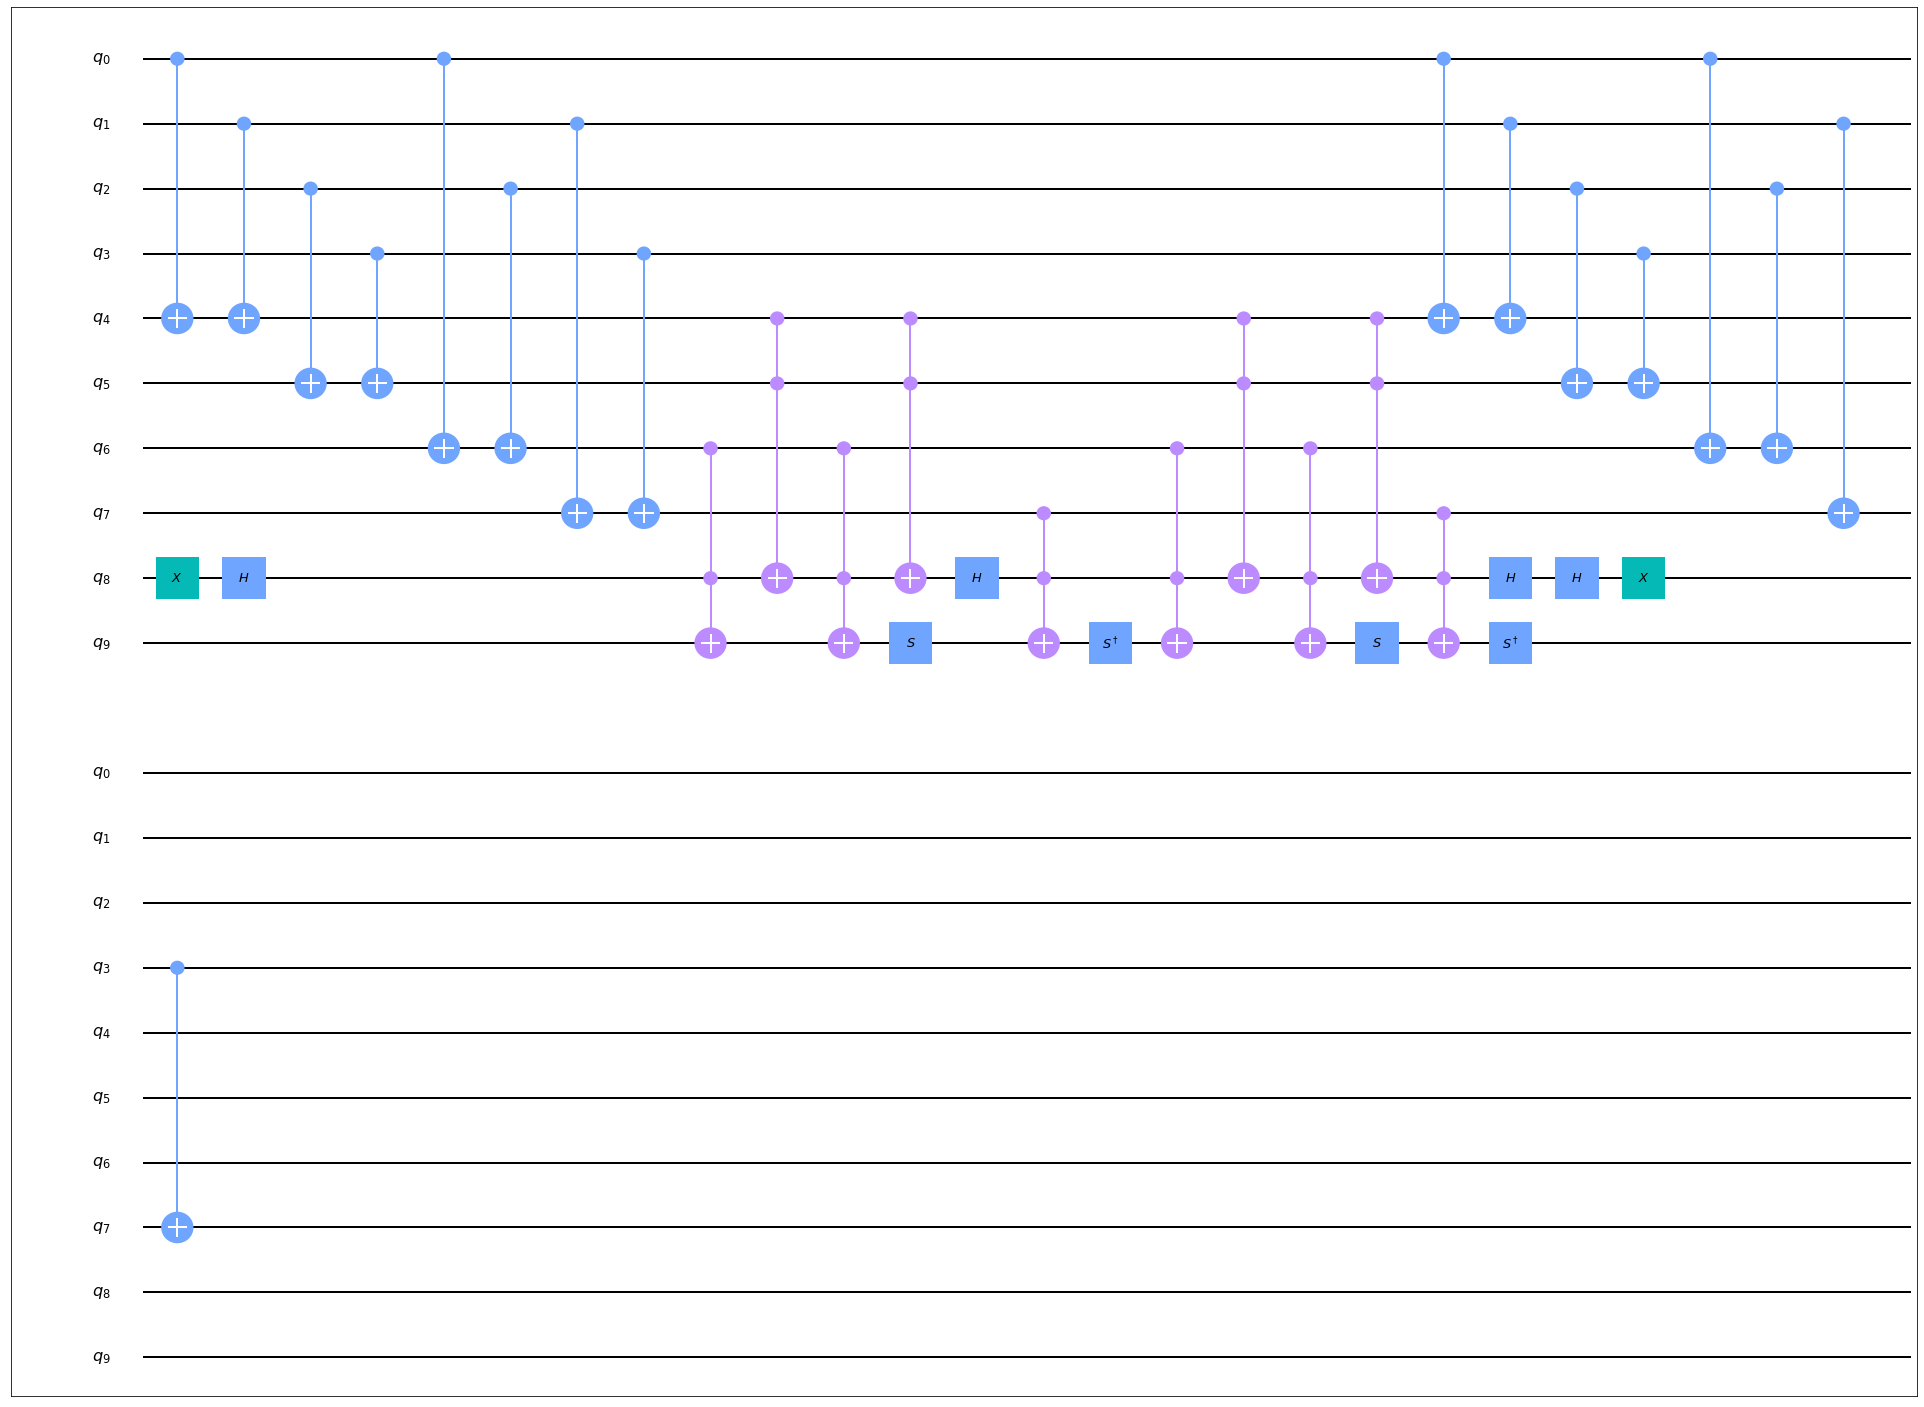

In [5]:
k,cgate = sudoku_oracle()
circ = Circuit(10)
cgate | circ
circ.draw()

Construct Grover search circuit on the oracle and run:

In [6]:
n = 4
k, oracle = sudoku_oracle()
circ = Grover.circuit(n, k, oracle, m=2)

amp = CircuitSimulator().run(circ)
x = bin(int(circ[list(range(n))]))[2:].rjust(4,'0')[::-1]
print(f'{x[0]}|{x[1]}\n-+-\n{x[2]}|{x[3]}')

INFO:root:circuit width          =   10
INFO:root:oracle  calls          =    2
INFO:root:other circuit size     =   64


0|1
-+-
1|0


/home/pengsirui/quict/QuICT/simulation/cpu_simulator/cpu.py:214: Warning: Attention! You are using a working-in-process version of circuit simulator!
  warnings.warn(


Consider another example with only one solution so we can compare `Grover` module and `PartialGrover` module.

There are 4 statements $x_i:\sum_j [x_j]=i, i=1,2,3,4$, and the problem is to decide the truth value of each staatement. Notice that these statements contradict each other therefore at most one of them is correct, then it is easy to check that $(True,True,False,True)$ is the only solution.

More precisely, $f(x)=\land_{i=1,2,3,4}((\neg x_i\land\sum_{j\neq i}[x_j]\neq i) \lor (x_i\land\sum_{j\neq i}[x_j]=i))$. But actually we use $f_a(x)=f(x)\land(\land_{i=4+1...4+a} x_i)$ to distinguish Grover and Partial Grover module.

Again we can construct the oracle and find solution with Grover module:

In [17]:
def sentence(control_q:int,local_var_q,clause_q:int,ancilla_q):
    assert len(local_var_q)==3 and len(ancilla_q)==2
    cgate = CompositeGate()
    with cgate:
        CX & [local_var_q[0],clause_q]
        CX & [local_var_q[1],clause_q]
        CX & [local_var_q[2],clause_q]
        CCX & [local_var_q[1],local_var_q[2],ancilla_q[0]]
        X & ancilla_q[0]
        CCX & [clause_q,ancilla_q[0],ancilla_q[1]]
        X & ancilla_q[0]
        #uncompute clause_q
        CX & [local_var_q[0],clause_q]
        CX & [local_var_q[1],clause_q]
        CX & [local_var_q[2],clause_q]

        X & ancilla_q[1]
        CCX & [control_q,ancilla_q[1],clause_q]
        X & ancilla_q[1]
        X & clause_q

        #uncompute ancilla_q
        X & ancilla_q[0]
        CCX & [local_var_q[0],ancilla_q[0],ancilla_q[1]]
        CCX & [local_var_q[1],ancilla_q[0],ancilla_q[1]]
        CCX & [local_var_q[2],ancilla_q[0],ancilla_q[1]]
        X & ancilla_q[0]
        CCX & [local_var_q[1],local_var_q[2],ancilla_q[0]]
    return cgate

def sentence_adjoint(control_q:int,local_var_q,clause_q:int,ancilla_q):
    assert len(local_var_q)==3 and len(ancilla_q)==2
    cgate = CompositeGate()
    with cgate:
        #uncompute ancilla_q
        CCX & [local_var_q[1],local_var_q[2],ancilla_q[0]]
        X & ancilla_q[0]
        CCX & [local_var_q[2],ancilla_q[0],ancilla_q[1]]
        CCX & [local_var_q[1],ancilla_q[0],ancilla_q[1]]
        CCX & [local_var_q[0],ancilla_q[0],ancilla_q[1]]
        X & ancilla_q[0]

        X & clause_q
        X & ancilla_q[1]
        CCX & [control_q,ancilla_q[1],clause_q]
        X & ancilla_q[1]

        CX & [local_var_q[2],clause_q]
        CX & [local_var_q[1],clause_q]
        CX & [local_var_q[0],clause_q]
        X & ancilla_q[0]
        CCX & [clause_q,ancilla_q[0],ancilla_q[1]]
        X & ancilla_q[0]
        CCX & [local_var_q[1],local_var_q[2],ancilla_q[0]]
        CX & [local_var_q[2],clause_q]
        CX & [local_var_q[1],clause_q]
        CX & [local_var_q[0],clause_q]
    return cgate

def CCCX(reg_q):
    assert len(reg_q)==5
    cgate = CompositeGate()
    with cgate:
        CCX & [reg_q[0],reg_q[1],reg_q[4]]
        H & [reg_q[3]]
        S & [reg_q[4]]
        CCX & [reg_q[2],reg_q[3],reg_q[4]]
        S_dagger & [reg_q[4]]
        CCX & [reg_q[0],reg_q[1],reg_q[4]]
        S & [reg_q[4]]
        CCX & [reg_q[2],reg_q[3],reg_q[4]]
        H & [reg_q[3]]
        S_dagger & [reg_q[4]]
    return cgate

def puzzle_oracle():
    n_true_var = 4
    n_var = 8
    n_clause = 4
    var_q = list(range(n_var))
    clause_q = list(range(n_var,n_var+n_clause))
    result_q = [n_var+n_clause]
    ancilla_q = [n_var+n_clause+1,n_var+n_clause+2]
    cgate = CompositeGate()
    with cgate:
        # # |-> in result_q
        X & result_q[0]
        H & result_q[0]
        # sentence1
        for i in [1,2,3]:
            X & i
        sentence(0,[1,2,3],clause_q[0],ancilla_q) | cgate
        for i in [1,2,3]:
            X & i
        # sentence2
        sentence(1,[0,2,3],clause_q[1],ancilla_q) | cgate
        # sentence3
        for i in [0,1,3]:
            X & i
        CCCX([0,1,3,clause_q[2],ancilla_q[1]]) | cgate
        X & clause_q[2]
        CCX & [2,clause_q[2],ancilla_q[0]]
        X & clause_q[2]
        CCCX([0,1,3,clause_q[2],ancilla_q[1]]) | cgate
        for i in [0,1,3]:
            X & i
        CX & [ancilla_q[0],clause_q[2]]
        CX & [clause_q[2],ancilla_q[0]]
        X & clause_q[2]
        # sentence4
        for i in [0,1,2,3]:
            X & i
        CCCX([0,1,2,ancilla_q[0],ancilla_q[1]]) | cgate
        X & ancilla_q[0]
        CCX & [3,ancilla_q[0],clause_q[3]]
        X & ancilla_q[0]
        CCCX([0,1,2,ancilla_q[0],ancilla_q[1]]) | cgate
        for i in [0,1,2,3]:
            X & i
        # MCT
        MCTOneAux.execute(n_var-n_true_var+len(clause_q)+2) & (var_q[n_true_var:n_var]+clause_q+result_q+[ancilla_q[0]])
        #uncompute clauses
        # |-> in result_q
        H & result_q[0]
        X & result_q[0]
        # sentence1
        for i in [1,2,3]:
            X & i
        sentence_adjoint(0,[1,2,3],clause_q[0],ancilla_q) | cgate
        for i in [1,2,3]:
            X & i
        # sentence2
        sentence_adjoint(1,[0,2,3],clause_q[1],ancilla_q) | cgate
        # sentence3
        X & clause_q[2]
        CX & [clause_q[2],ancilla_q[0]]
        CX & [ancilla_q[0],clause_q[2]]
        for i in [0,1,3]:
            X & i
        CCCX([0,1,3,clause_q[2],ancilla_q[1]]) | cgate
        X & clause_q[2]
        CCX & [2,clause_q[2],ancilla_q[0]]
        X & clause_q[2]
        CCCX([0,1,3,clause_q[2],ancilla_q[1]]) | cgate
        for i in [0,1,3]:
            X & i
        # sentence4
        for i in [0,1,2,3]:
            X & i
        CCCX([0,1,2,ancilla_q[0],ancilla_q[1]]) | cgate
        X & ancilla_q[0]
        CCX & [3,ancilla_q[0],clause_q[3]]
        X & ancilla_q[0]
        CCCX([0,1,2,ancilla_q[0],ancilla_q[1]]) | cgate
        for i in [0,1,2,3]:
            X & i
    return 7, cgate

INFO:root:circuit width          =   15
INFO:root:oracle  calls          =   13
INFO:root:other circuit size     =  944
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


success rate = 0.9861862401018322


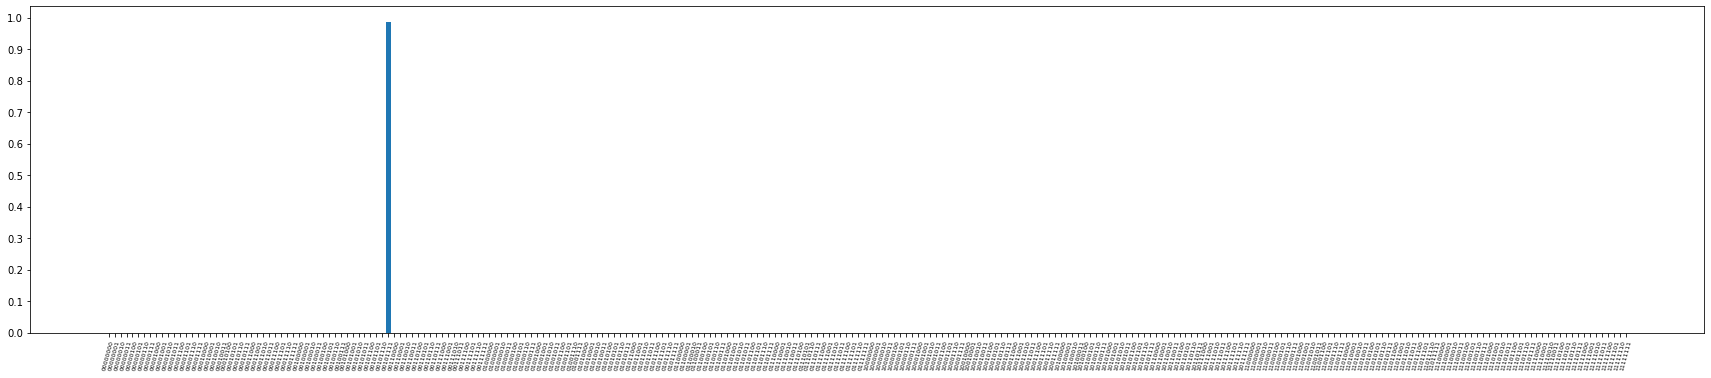

In [30]:
n = 8
k, oracle = puzzle_oracle()
circ = Grover.circuit(n, k, oracle, measure=False)

amp = CircuitSimulator().run(circ)
names = [bin(i)[2:].rjust(n,'0') for i in range(1<<n)]
values = trace_prob(amp,list(range(n))).reshape([1<<n])
print(f"success rate = {sum([values[i] if bin(i)[2:].rjust(n,'0')=='00101111' else 0 for i in range(len(values))])}")

import matplotlib.pyplot as plt
plt.figure(figsize=(30,6))
plt.bar(names, values)
plt.xticks(fontsize=6,rotation=75)
plt.yticks(ticks=[i/10 for i in range(11)])
plt.show()

Construct Partial Grover search circuit on same oracle and run:

INFO:root:circuit width           =   16
INFO:root:global Grover iteration =    8
INFO:root:local  Grover iteration =    3
INFO:root:oracle  calls           =   12
INFO:root:other circuit size      = 1048


run with n = 8, block size = 3


/home/pengsirui/quict/QuICT/simulation/cpu_simulator/cpu.py:214: Warning: Attention! You are using a working-in-process version of circuit simulator!
  warnings.warn(
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


success rate = 0.797729908327687


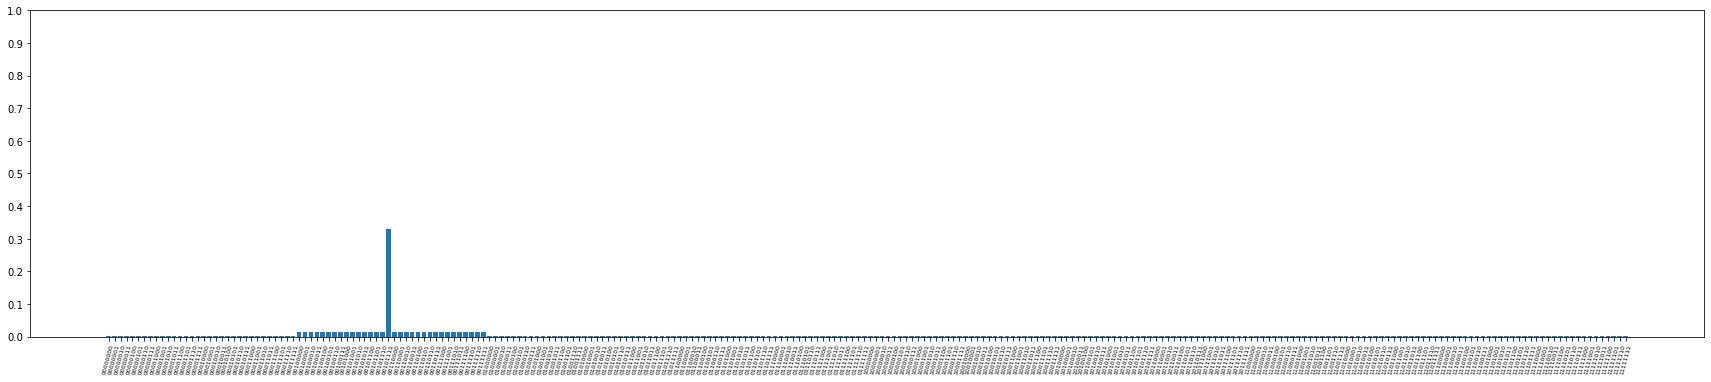

In [26]:
n = 8
n_block = 3
print(f"run with n = {n}, block size = {n_block}")
k, oracle = puzzle_oracle()
circ = PartialGrover.circuit(n, n_block, k, oracle, measure=False)

from QuICT.simulation.cpu_simulator import CircuitSimulator
amp = CircuitSimulator().run(circ)
names = [bin(i)[2:].rjust(n,'0') for i in range(1<<n)]
values = trace_prob(amp,list(range(n))).reshape([1<<n])
print(f"success rate = {sum([values[i] if bin(i)[2:].rjust(n,'0')[:3]=='001' else 0 for i in range(len(values))])}")

import matplotlib.pyplot as plt
plt.figure(figsize=(30,6))
plt.bar(names, values)
plt.xticks(fontsize=6,rotation=75)
plt.yticks(ticks=[i/10 for i in range(11)])
plt.show()

Example above demonstrates the fact that partial search uses fewer Oracle calls and only aims to find block address. A detailed comparison is given below:

| algorithm              | Grover(with unique target)   | Partial Grover                                |
| ---------------------- | ---------------------------- | --------------------------------------------- |
| expected output        | target address $a=a_1...a_n$ | block address of target $a_{block}=a_1...a_k$ |
| oracle calls           | $\approx\pi/4\sqrt{N}$       | $\approx\pi/4\sqrt{N}-0.34\sqrt{N/K}$         |
| other elementary gates | $O(\sqrt{N}\log N)$          | $O(\sqrt{N}\log N)$                           |
| success rate           | $1-O(N^{-1/2})$              | $1-O(N^{-1/4})$                               |

## Shor Module

This module includes four implementations of Shor factoring algorithm[3][4], which differs in the operator $U\ket{y}\equiv \ket{xy(\text{mod }N)}$ and usage of one-bit trick. 

The quantum part of Shor's factoring algorithm is the order-finding circuit, which can be split into Quantum Phase Estimation (QPE) circuit and modular exponentiation circuit. By using two different constructions of QPE circuit (with or without the one-qubit-trick) and two different constructions of modular exponentiation circuit (in `QuICT.qcda.synthesis.arithmetic.bea` and `QuICT.qcda.synthesis.arithmetic.hrs`), four implementations of Shor's factoring algorithm is given. 

QPE with one-bit trick:

<center>
<img src='./one_bit_trick.png'>
</center>

The following procedure gives full algorithm[1] including the classical part:

- Inputs: A composite number $N$
- Outputs: A non-trivial factor of $N$
- Runtime: $O((\log N)^3)$ operations. Succeeds with probability $O(1)$.

1. If $N$ is even, return the factor $2$.
2. classically determine whether $N=a^b,\exist a\geq 1,b\geq 2$. if yes return $a$.
3. Randomly choose $x$ in the range $1$ to $N−1$. If $gcd(x, N) > 1$ then return the factor $gcd(x, N)$.
4. run order-finding subroutine $k$ times to get the phase $s_i/r_i,i=1...k$, then run continued fractions algorithm (discard zero result) to get $r_i,i=1...{k'}$, then use $r=lcm(r_1...r_{k'})$ as order.
5. If order $r$ is even and $x^{r/2} = − 1(mod N)$ then compute $gcd(x^{r/2} − 1, N)$ and $gcd(x^{r/2 + 1}, N)$, and test to see if one of these is a non-trivial factor, returning that factor if so. Otherwise, goto step 3 until max iteration limits is reached. In that case, the algorithm fails.

### example

Use `ShorFactor(mode, N).run()` to factor a number $N$:

In [31]:
# logger.setLevel(logging.WARNING)

from QuICT.algorithm.quantum_algorithm import ShorFactor

input  = 35
sf = ShorFactor(mode="BEA_zip", N=input, max_rd=1)
circ, indices = sf.circuit()

output = sf.run(simulator=ConstantStateVectorSimulator(), circuit=circ, indices=indices, forced_quantum_approach=True)
print(f"input  = {input}")
print(f"output = {output}")

INFO:root:	circuit construction begin: circuit: n = 6 t = 15
INFO:root:forced quantum approach, looking for coprime number...
INFO:root:round = 0
INFO:root:Quantumly determine the order of the randomly chosen a = 22
INFO:root:phi: 0.500
INFO:root:Shor succeed: found factor 7, with the help of a = 22, r = 2


input  = 35
output = 7


### Error rate

The behaviour of order-finding algorithm is consistent with theoretical prediction. 

| mode    | original   | reinforced(MAX_ROUND=3)         | $Pr(r\neq 0\text{ and }r\nmid\text{order}(a,N))$  | repetitions |
| ------- | ---------- | ------------------------------- | ---------------------------------------- |---------------|
| BEA     | 0.47       | 0.12                            | 0                                        | 108 |
| BEA_zip | 0.48       | 0.11                            | 0                                        | 108 |
| HRS     | 0.44       | 0.06                            | 0                                        | 108 |
| HRS_zip | 0.44       | 0.03                            | 0                                        | 108 |

The data set is composites in $[4,54)$, 36 in total and 9 of them are odd composites.

`original` refers to the **original** procedure given above, and `forced` is only different in step 3, where we pick a random number $x$ that $gcd(x,N)=1$ to **force** the execution of order-finding subroutine. The number refers to repetition of order-finding subroutines in step 4.

| mode    | original-2 | forced-2 | original-3 | forced-3 |
| ------- | ---------- | -------- | ---------- | :------- |
| BEA_zip | 0.028      | 0.028    | 0.0        | 0.0      |
| HRS_zip | 0.028      | 0.028    | 0.0        | 0.0      |

## References

[1] Nielsen, M. A., & Chuang, I. L. (2019). Quantum computation and quantum information. Cambridge Cambridge University Press.

[2] Grover, L. K., & Radhakrishnan, J. (2005). Is partial quantum search of a database any easier? Proceedings of the 17th Annual ACM Symposium on Parallelism in Algorithms and Architectures - SPAA’05. https://doi.org/10.1145/1073970.1073997

[3] Beauregard, S. (2003). Circuit for Shor’s algorithm using 2n+3 qubits. Quantum Information and Computation, 3(2), 175–185. https://doi.org/10.26421/qic3.2-8

[4] Haner, T., Roetteler, M., & Svore, K. M. (2017). Factoring using 2n+2 qubits with Toffoli based modular multiplication. Quantum Information and Computation, 17(7&8), 673–684. https://doi.org/10.26421/qic17.7-8-7

[5] He, Y., Luo, MX., Zhang, E. et al. (2017). Decompositions of n-qubit Toffoli Gates with Linear Circuit Complexity. Int J Theor Phys, 56, 2350–2361. https://doi.org/10.1007/s10773-017-3389-4